# Pre processing and data augmentaion

This notebook focuses on data pre processing and augmentation. All of these operations are made prior to model training. Pre-processed data is saved to separate directories, that the training loop will have access to.

In [1]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
import sys

# Append the path to access custom modules
if '../' not in sys.path:
    sys.path.append('../')

import src.preprocessing.preprocess as pr
import src.modules.plotting as p
import src.utils.dataset_helper as dh
import src.utils.data_splitter as ds

from importlib import reload

In [19]:
reload(pr);
reload(dh);
reload(p);
reload(ds);

- Get the helper and the pre processing static classes

In [3]:
helper = dh.DatasetHelper

- Get csv datasets

In [4]:
train_df = pd.read_csv('../data/csv/train_clean.csv')
val_df = pd.read_csv('../data/csv/validation_clean.csv')
test_df = pd.read_csv('../data/csv/test.csv')

- Sort the train instances, in order to match the order of the image dataset

In [5]:
train_df = train_df.drop(columns='Unnamed: 0').sort_values(by='MR_session').reset_index(drop=True)
val_df = val_df.drop(columns='Unnamed: 0').sort_values(by='MR_session').reset_index(drop=True)
test_df = test_df.drop(columns='Unnamed: 0').sort_values(by='MR_session').reset_index(drop=True)

- Declare the path of the directories that contains the image datasets

In [6]:
base_dir_train = os.path.join('..', 'data', 'train')
base_dir_test = os.path.join('..', 'data', 'test')
base_dir_val = os.path.join('..', 'data', 'validation')

- Declare the file names to pre-process

In [7]:
left_hippo = 'hippocampus_left.nii.gz'
left_hippo_processed = 'hippocampus_left_processed.nii.gz'

right_hippo = 'hippocampus_right.nii.gz'
right_hippo_processed = 'hippocampus_right_processed.nii.gz'

## Dataset definition for standard pre-processing

- Using the `get_datasets` API we retrieve for each set a dictionary containing the dataset for left and right hippocampus. These can be accessed using the 'left' and 'right' keywork


### Train datasets


In [8]:
train_datasets = pr.get_datasets(
    base_dir=base_dir_train, 
    experiments=train_df['MR_session'], 
    labels=train_df['label'], 
    left_file_name=left_hippo, 
    right_file_name=right_hippo
)

### Validation datasets

In [9]:
validation_datasets = pr.get_datasets(
    base_dir=base_dir_val, 
    experiments=val_df['MR_session'], 
    labels=val_df['label'],
    left_file_name=left_hippo, 
    right_file_name=right_hippo
)

### Test datasets


In [10]:
test_datasets = pr.get_datasets(
    base_dir=base_dir_test, 
    experiments=test_df['MR_session'], 
    labels=test_df['label'],
    left_file_name=left_hippo, 
    right_file_name=right_hippo
)

## Determine images final dimension

- To train a model every instance needs to have the same spatial size
- The data are by default cropped, which results in every instance having different shapes
- To correctly apply a resize operation at the very end of the pre processing pipeline, it is necessary to gather some more information about the maximum size of each image's dimension (after undergoing to a crop transform)

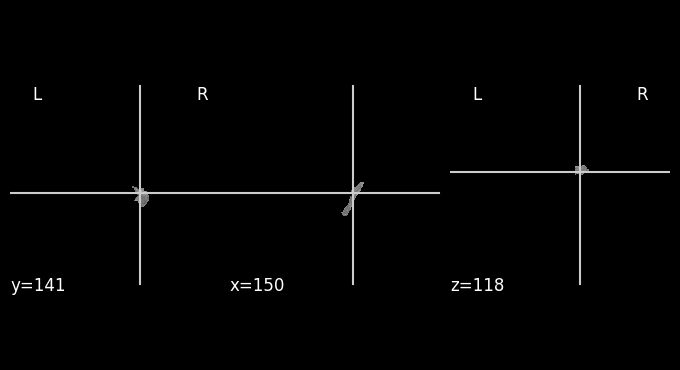

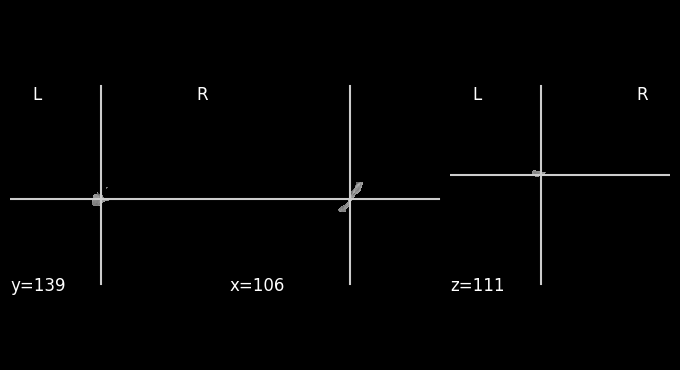

In [21]:
from nilearn import plotting
plotting.plot_anat(nib.load('../data/segmented/OAS30004_MR_d1101/mri/hippocampus_left.nii.gz'))
plotting.plot_anat(nib.load('../data/segmented/OAS30004_MR_d1101/mri/hippocampus_right.nii.gz'))

In [22]:
pr.max_size_after_crop(train_datasets, validation_datasets, test_datasets)

Training set


Image processing:   0%|          | 0/778 [00:00<?, ?it/s]

Image processing:   0%|          | 0/778 [00:00<?, ?it/s]

Validation set


Image processing:   0%|          | 0/106 [00:00<?, ?it/s]

Image processing:   0%|          | 0/106 [00:00<?, ?it/s]

Test set


Image processing:   0%|          | 0/135 [00:00<?, ?it/s]

Image processing:   0%|          | 0/135 [00:00<?, ?it/s]

50

In [21]:
SPATIAL_SIZE = (52, 52)

default_operations = lambda size: pr.operations.STD_PREPROCESS + [
        pr.operations.CROP, 
        pr.operations.get_pad(size[0]),
        pr.operations.get_resize(size[1]), 
]

## Adjust the images contrast

- Check the result of one single example before applying contrast fixing to all the images

[<monai.transforms.utility.dictionary.EnsureChannelFirstd object at 0x0000019D88BE7E00>, <monai.transforms.utility.dictionary.EnsureTyped object at 0x0000019D88C70F50>, <monai.transforms.spatial.dictionary.Spacingd object at 0x0000019D88B56B10>, <monai.transforms.intensity.dictionary.ScaleIntensityd object at 0x0000019D88C83410>, <monai.transforms.croppad.dictionary.CropForegroundd object at 0x0000019D88C82B40>, <monai.transforms.croppad.dictionary.SpatialPadd object at 0x0000019D88C7B050>, <monai.transforms.spatial.dictionary.Resized object at 0x0000019D88B3AD80>]


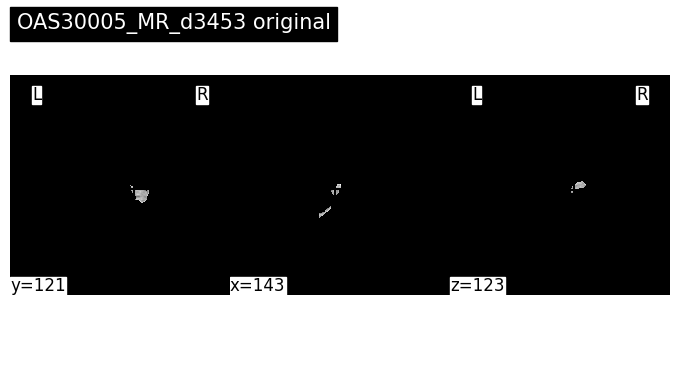

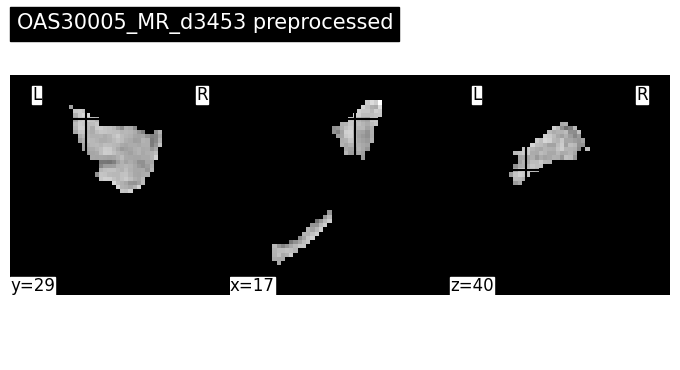

In [22]:
p.processed_example_comparison_plot(
    *pr.test_preprocessing(train_datasets['left'], operations=default_operations(SPATIAL_SIZE))
)

- Apply preprocessing on training set

In [23]:
pr.execute_pre_processing(
    save_dir_name='train_preprocess',
    datasets=train_datasets,
    left_file_name=left_hippo_processed,
    right_file_name=right_hippo_processed,
    operations=default_operations(SPATIAL_SIZE)
)

Processing left hippocampus:   0%|          | 0/778 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/778 [00:00<?, ?it/s]

- Apply preprocessing on validation set

In [24]:
pr.execute_pre_processing(
    save_dir_name='validation_preprocess',
    datasets=validation_datasets,
    left_file_name=left_hippo_processed,
    right_file_name=right_hippo_processed,
    operations=default_operations(SPATIAL_SIZE)
)

Processing left hippocampus:   0%|          | 0/106 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/106 [00:00<?, ?it/s]

- Apply preprocessing on test set

In [25]:
pr.execute_pre_processing(
    save_dir_name='test_preprocess',
    datasets=test_datasets,
    left_file_name=left_hippo_processed,
    right_file_name=right_hippo_processed,
    operations=default_operations(SPATIAL_SIZE)
)

Processing left hippocampus:   0%|          | 0/135 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/135 [00:00<?, ?it/s]

- Check the results by plottig a random example

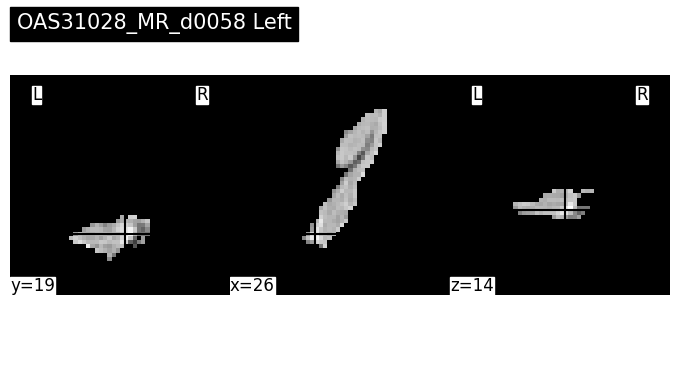

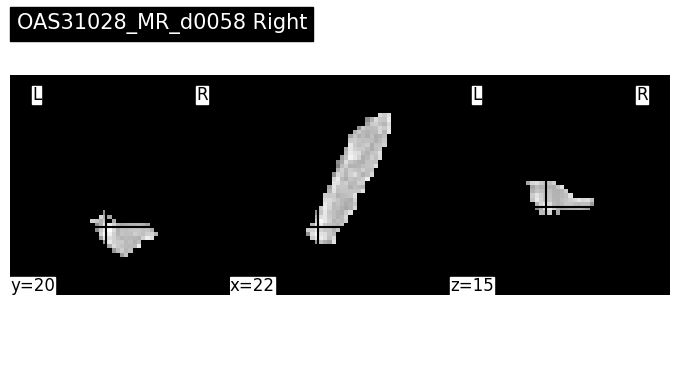

In [27]:
p.plot_img_by_experiment_id(
    dir='../data/train_preprocess',
    id=train_df['MR_session'].sample(1, random_state=42).values[0],
    file_name_left=left_hippo_processed,
    file_name_right=right_hippo_processed
)

## Train set augmentation
- In this section train and validation sets will be augmented with the operations defined in the previous notebook
- Let's load the training csv dataset where these additional instances are defined

In [28]:
full_train_set_df = pd.read_csv('../data/csv/train.csv')

In [29]:
full_train_set_df['label'].value_counts()

label
Cognitevely-normal    400
Demented              400
Early-stage           400
Name: count, dtype: int64

- Sort the instances and drop cognitevely normal patients from the train set

In [30]:
full_train_set_df = (
    full_train_set_df
        .drop(
            columns='Unnamed: 0', 
            index=full_train_set_df[full_train_set_df['label'] == 'Non-Demented'].index
        )
        .sort_values(by='MR_session')
        .reset_index(drop=True)
)

- Drop instances that refer to NO augmentation in the train set

In [31]:
full_train_set_df = full_train_set_df.drop(
    index=full_train_set_df[full_train_set_df['augmentation'] == 'normal'].index
)

- Define sub-dataframe that will be the input for the pre-processing module

In [32]:
aug_mci_train_df = full_train_set_df[full_train_set_df['label'] == 'Early-stage']
aug_dem_train_df = full_train_set_df[full_train_set_df['label'] == 'Demented']

## Datasets definition for augmentation

- This section is dedicated in the definition of the datasets made with that instances that will be augmented
- The augmentation ids are defined here

In [33]:
augs = ['flip', 'rot30', 'rot60', 'rot90']

- To be consistent with the APIs of the `preprocessing` module we have to consider 4 different datasets, one for every different augmentation type (flip, rot30, rot90, ro150)
- A dictionary to improve the access of the datasets inside the lists created above

In [34]:
indexer = {aug: i for i, aug in enumerate(augs)}
indexer

{'flip': 0, 'rot30': 1, 'rot60': 2, 'rot90': 3}

- Augmentation operation dictionary

In [35]:
aug_ops = {
    'rot60': [pr.operations.get_rotation(60)],
    'rot30': [pr.operations.get_rotation(30)],
    'rot90': [pr.operations.get_rotation(90)],
    'flip': [pr.operations.FLIP]
}

### MCI dataset

- Datasets with MCI instances from the training set to augment:

In [36]:
mci_train_datasets = [
    pr.get_datasets(
        base_dir=base_dir_train, 
        experiments=aug_mci_train_df[aug_mci_train_df['augmentation'] == aug]['MR_session'], 
        labels=aug_mci_train_df[aug_mci_train_df['augmentation'] == aug]['label'],
        left_file_name=left_hippo, 
        right_file_name=right_hippo
    )
    for aug in augs 
]

#### Visualize a MCI augmentations example

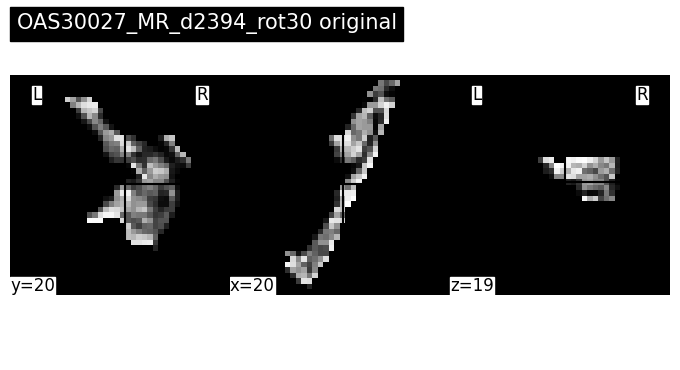

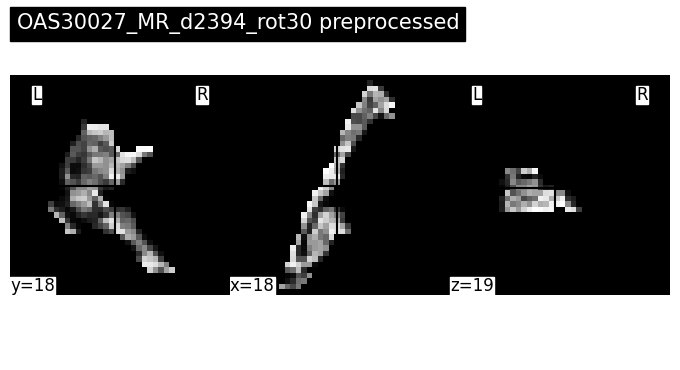

In [43]:
i = indexer['flip']

_, img_orig, exp = pr.test_preprocessing(mci_train_datasets[i]['left'], pr.operations.CONTRAST)
_, img_proc, exp = pr.test_preprocessing(mci_train_datasets[i]['left'], pr.operations.CONTRAST + aug_ops['flip'])

p.processed_example_comparison_plot(img_orig, img_proc, subject=exp)

### Demented dataset

- Datasets with Demented instances from the training set to augment:
    1. Only instances to flip
    2. Only instances to rotate by 150 degrees
    3. Only instances to rotate by 30 degrees
    4. Only instances to rotate by 90 degrees

In [37]:
dem_train_datasets = [
    pr.get_datasets(
        base_dir=base_dir_train, 
        experiments=aug_dem_train_df[aug_dem_train_df['augmentation'] == aug]['MR_session'], 
        labels=aug_dem_train_df[aug_dem_train_df['augmentation'] == aug]['label'],
        left_file_name=left_hippo, 
        right_file_name=right_hippo
    )
    for aug in augs 
]

### Visualize the effect of a flip

[<monai.transforms.utility.dictionary.EnsureChannelFirstd object at 0x0000019D88BE7E00>, <monai.transforms.utility.dictionary.EnsureTyped object at 0x0000019D88C70F50>, <monai.transforms.spatial.dictionary.Spacingd object at 0x0000019D88B56B10>, <monai.transforms.intensity.dictionary.ScaleIntensityd object at 0x0000019D88C83410>, <monai.transforms.croppad.dictionary.CropForegroundd object at 0x0000019D88C82B40>, <monai.transforms.croppad.dictionary.SpatialPadd object at 0x0000019D88C74980>, <monai.transforms.spatial.dictionary.Resized object at 0x0000019D88C70920>]
[<monai.transforms.utility.dictionary.EnsureChannelFirstd object at 0x0000019D88BE7E00>, <monai.transforms.utility.dictionary.EnsureTyped object at 0x0000019D88C70F50>, <monai.transforms.spatial.dictionary.Spacingd object at 0x0000019D88B56B10>, <monai.transforms.intensity.dictionary.ScaleIntensityd object at 0x0000019D88C83410>, <monai.transforms.croppad.dictionary.CropForegroundd object at 0x0000019D88C82B40>, <monai.trans

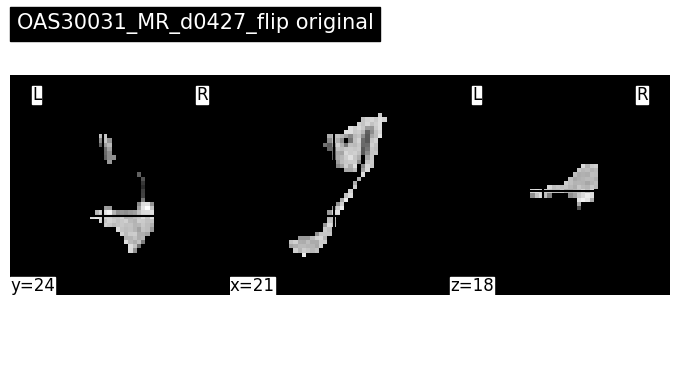

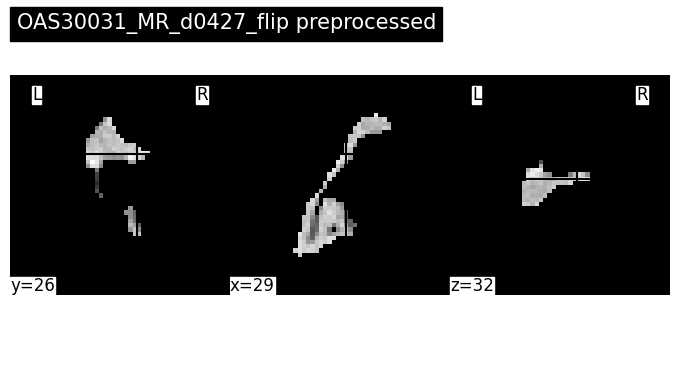

In [38]:
i = indexer['flip']

_, img_orig, exp = pr.test_preprocessing(dem_train_datasets[i]['left'], default_operations(SPATIAL_SIZE))
_, img_proc, exp = pr.test_preprocessing(dem_train_datasets[i]['left'], default_operations(SPATIAL_SIZE) + aug_ops['flip'])

p.processed_example_comparison_plot(img_orig, img_proc, subject=exp)

## Executing Augmentation

### Train set MCI data

In [39]:
for aug in augs:
    print(aug)
    pr.execute_pre_processing(
        save_dir_name='train_preprocess',
        datasets=mci_train_datasets[indexer[aug]],
        operations=default_operations(SPATIAL_SIZE) + aug_ops[aug],
        left_file_name=left_hippo_processed,
        right_file_name=right_hippo_processed,
    )

flip


Processing left hippocampus:   0%|          | 0/30 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/30 [00:00<?, ?it/s]

rot30


Processing left hippocampus:   0%|          | 0/28 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/28 [00:00<?, ?it/s]

rot60


Processing left hippocampus:   0%|          | 0/25 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/25 [00:00<?, ?it/s]

rot90


Processing left hippocampus:   0%|          | 0/26 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/26 [00:00<?, ?it/s]

- Visualize the results of MCI augmentation

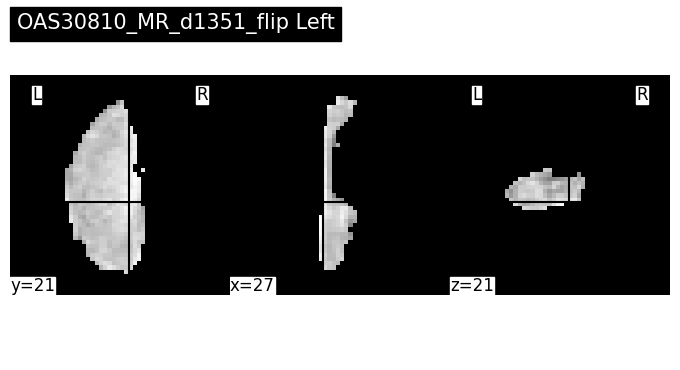

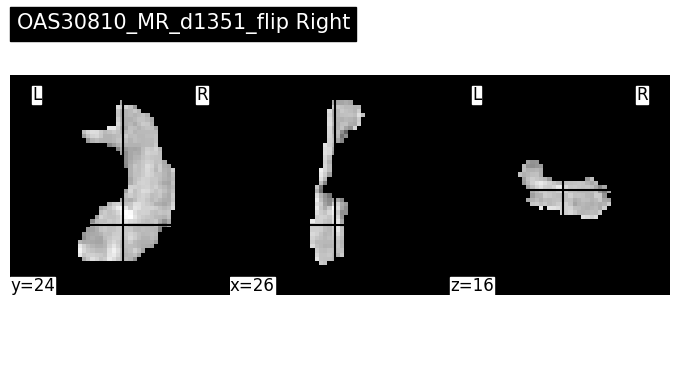

In [41]:
p.plot_img_by_experiment_id(
    dir=os.path.join('..', 'data', 'train_preprocess'),
    id=aug_mci_train_df['MR_session'].sample(n=1).to_list()[0],
    file_name_left=left_hippo_processed,
    file_name_right=right_hippo_processed
)

### Train set demented data

In [42]:
for aug in augs:
    print(aug)
    if aug != 'rot45':
        pr.execute_pre_processing(
            save_dir_name='train_preprocess',
            datasets=dem_train_datasets[indexer[aug]],
            operations=default_operations(SPATIAL_SIZE) + aug_ops[aug],
            left_file_name=left_hippo_processed,
            right_file_name=right_hippo_processed,
        )

flip


Processing left hippocampus:   0%|          | 0/78 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/78 [00:00<?, ?it/s]

rot30


Processing left hippocampus:   0%|          | 0/79 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/79 [00:00<?, ?it/s]

rot60


Processing left hippocampus:   0%|          | 0/77 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/77 [00:00<?, ?it/s]

rot90


Processing left hippocampus:   0%|          | 0/79 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/79 [00:00<?, ?it/s]

- Visualize a random result of demented augmentation

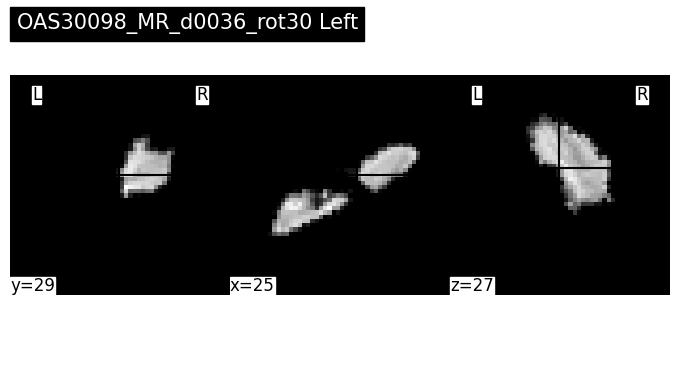

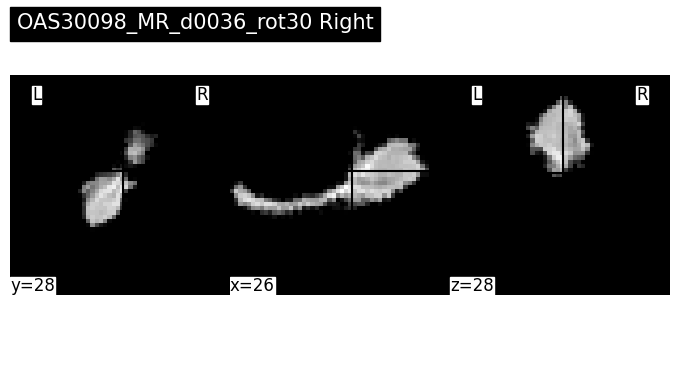

In [43]:
p.plot_img_by_experiment_id(
    dir=os.path.join('..', 'data', 'train_preprocess'),
    id=aug_dem_train_df['MR_session'].sample(n=1).to_list()[0],
    file_name_left=left_hippo_processed,
    file_name_right=right_hippo_processed
)

## Validation set augmentation
- In this section train and validation sets will be augmented with the operations defined in the previous notebook
- Let's load the training csv dataset where these additional instances are defined

In [54]:
full_val_set_df = pd.read_csv('../data/csv/validation.csv')

In [57]:
full_val_set_df = (
    full_val_set_df
        .drop(
            columns='Unnamed: 0', 
            index=full_val_set_df[full_val_set_df['label'] == 'Non-Demented'].index
        )
        .sort_values(by='MR_session')
        .reset_index(drop=True)
)

In [58]:
full_val_set_df = full_val_set_df.drop(
    index=full_val_set_df[full_val_set_df['augmentation'] == 'normal'].index
)

In [59]:
aug_mci_validation_df = full_val_set_df[full_val_set_df['label'] == 'Early-stage']
aug_dem_validation_df = full_val_set_df[full_val_set_df['label'] == 'Demented']

In [61]:
mci_validation_datasets = [
        pr.get_datasets(
                base_dir=base_dir_val, 
                experiments=aug_mci_validation_df[aug_mci_validation_df['augmentation'] == aug]['MR_session'], 
                labels=aug_mci_validation_df[aug_mci_validation_df['augmentation'] == aug]['label'],
                left_file_name=left_hippo, 
                right_file_name=right_hippo
        )
        for aug in augs 
]

In [63]:
for aug in augs:
    print(aug)
    pr.execute_pre_processing(
        save_dir_name='validation_preprocess',
        datasets=mci_validation_datasets[indexer[aug]],
        operations=default_operations(SPATIAL_SIZE) + aug_ops[aug],
        left_file_name=left_hippo_processed,
        right_file_name=right_hippo_processed,
    )

flip


Processing left hippocampus:   0%|          | 0/6 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/6 [00:00<?, ?it/s]

rot30


Processing left hippocampus:   0%|          | 0/7 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/7 [00:00<?, ?it/s]

rot60


Processing left hippocampus:   0%|          | 0/7 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/7 [00:00<?, ?it/s]

rot90


Processing left hippocampus:   0%|          | 0/7 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/7 [00:00<?, ?it/s]

In [64]:
dem_validation_datasets = [
    pr.get_datasets(
        base_dir=base_dir_val, 
        experiments=aug_dem_validation_df[aug_dem_validation_df['augmentation'] == aug]['MR_session'], 
        labels=aug_dem_validation_df[aug_dem_validation_df['augmentation'] == aug]['label'],
        left_file_name=left_hippo, 
        right_file_name=right_hippo
    )
    for aug in augs 
]

In [67]:
for aug in augs:
    print(aug)
    pr.execute_pre_processing(
        save_dir_name='validation_preprocess',
        datasets=dem_validation_datasets[indexer[aug]],
        operations=default_operations(SPATIAL_SIZE) + aug_ops[aug],
        left_file_name=left_hippo_processed,
        right_file_name=right_hippo_processed,
    )

flip


Processing left hippocampus:   0%|          | 0/10 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/10 [00:00<?, ?it/s]

rot30


Processing left hippocampus:   0%|          | 0/11 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/11 [00:00<?, ?it/s]

rot60


Processing left hippocampus:   0%|          | 0/11 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/11 [00:00<?, ?it/s]

rot90


Processing left hippocampus:   0%|          | 0/12 [00:00<?, ?it/s]

Processing right hippocampus:   0%|          | 0/12 [00:00<?, ?it/s]